In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.colors as mcolors

import sys
import scipy.stats as stats
import scipy.optimize as opt
from scipy.spatial import ConvexHull
from scipy.spatial.distance import pdist, squareform

import os

import pyarrow as pa
import pyarrow.parquet as pq

from enum import Enum

from matplotlib.backends.backend_pdf import PdfPages 
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

import sklearn
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans
# 30 sec

In [16]:
sys.path.append('/groups/icecube/cyan/Utils')
from PlotUtils import setMplParam, getColour, getHistoParam 
from ExternalFunctions import nice_string_output, add_text_to_ax
setMplParam()

In [17]:
sys.path.append('/groups/icecube/cyan/factory/DOMification')
from Enum.Flavour import Flavour
from Enum.EnergyRange import EnergyRange
from EventPeek.PseudoNormaliser import PseudoNormaliser

In [18]:
root_dir_noCR_CC_IN = "/lustre/hpc/project/icecube/HE_Nu_Aske_Oct2024/PMTfied_filtered/Snowstorm/CC_CRclean_Contained/"

In [19]:
def get_interesting_events(truth_file:str, N_doms_cut = 1250):
    truth_df = pq.read_table(truth_file).to_pandas()
    N_doms = truth_df["N_doms"]
    
    interesting_event_no = truth_df[["event_no", "shard_no", "energy"]][N_doms > N_doms_cut]
    return interesting_event_no

In [20]:
def get_normalised_dom_features(pmt_event_df: pd.DataFrame, Q_cut: float = -1) -> pd.DataFrame:
    selected_columns = ["dom_x", "dom_y", "dom_z", "Qtotal", "t1"]
    event_np = pmt_event_df[selected_columns].to_numpy()
    normaliser = PseudoNormaliser()
    
    normalised_np = normaliser(event_np, column_names=selected_columns)
    normalised_df = pd.DataFrame(normalised_np, columns=selected_columns)
    normalised_df[["dom_x", "dom_y", "dom_z"]] = pmt_event_df[["dom_x", "dom_y", "dom_z"]].to_numpy()
    normalised_df = normalised_df[normalised_df["Qtotal"] > Q_cut] if Q_cut is not None else normalised_df

    return normalised_df

In [21]:
def add_string_column_to_event_df(event_df: pd.DataFrame, ref_position_df: pd.DataFrame, tolerance=2.0):
    event_df = event_df.copy()
    event_df['string'] = np.nan

    x_diff = np.square(ref_position_df['dom_x'].values[:, None] - event_df['dom_x'].values)
    y_diff = np.square(ref_position_df['dom_y'].values[:, None] - event_df['dom_y'].values)
    
    distances = np.sqrt(x_diff + y_diff)
    min_indices = np.argmin(distances, axis=0)

    within_tolerance = np.min(distances, axis=0) <= tolerance
    event_df.loc[within_tolerance, 'string'] = ref_position_df.iloc[min_indices[within_tolerance]]['string'].values

    return event_df

In [22]:
def calculate_horizontal_boundary(pmt_event_df: pd.DataFrame):
    xy_points = pmt_event_df[['dom_x', 'dom_y']].to_numpy()
    hull = ConvexHull(xy_points)
    boundary_points = xy_points[hull.vertices]  
    return boundary_points

In [23]:
def compute_max_extent(boundary_points):
    dist_matrix = squareform(pdist(boundary_points))  # Compute all pairwise distances
    i, j = np.unravel_index(np.argmax(dist_matrix), dist_matrix.shape)  # Find indices of max distance
    point1, point2 = boundary_points[i], boundary_points[j]
    
    return point1, point2, dist_matrix[i, j]

In [24]:
def find_gmm_centres(string_df: pd.DataFrame, n_components=2):
    if string_df.shape[0] < n_components:
        return None, None  # Not enough points for clustering

    points = string_df[['dom_x', 'dom_y']].to_numpy()
    weights = string_df['Qtotal'].to_numpy()

    # Normalise and scale weights for duplication
    weights = np.clip((weights / (weights.max() + 1e-7)) * 10, 1, 10).astype(int)

    # Expand dataset by repeating points based on their weights
    weighted_points = np.repeat(points, weights, axis=0)

    gmm = GaussianMixture(n_components=n_components, covariance_type='full')
    gmm.fit(weighted_points)  # No `sample_weight` needed

    centres = gmm.means_
    cluster_dist = np.linalg.norm(centres[0] - centres[1])  # Distance between clusters
    std_dev = np.std(points, axis=0).mean()
    separation_score = cluster_dist / (std_dev + 1e-7)

    return centres, separation_score

In [25]:
def find_kmeans_centres(string_df: pd.DataFrame, n_clusters=2):
    if string_df.shape[0] < n_clusters:
        return None, None  # Not enough points for clustering

    points = string_df[['dom_x', 'dom_y']].to_numpy()
    weights = string_df['Qtotal'].to_numpy()

    # Normalise and scale weights for duplication
    weights = np.clip((weights / (weights.max() + 1e-7)) * 10, 1, 10).astype(int)

    # Expand dataset by repeating points based on weights
    weighted_points = np.repeat(points, weights, axis=0)

    kmeans = KMeans(n_clusters=n_clusters, n_init=10, random_state=42)
    kmeans.fit(weighted_points)

    centres = kmeans.cluster_centers_
    cluster_dist = np.linalg.norm(centres[0] - centres[1])

    # Normalise distance
    std_dev = np.std(points, axis=0).mean()
    separation_score = cluster_dist / (std_dev + 1e-7)

    return centres, separation_score


In [26]:
def compute_inverse_compactness(string_df: pd.DataFrame):
    """
    Compute inverse compactness score: Higher values indicate more elongated or dispersed structures.

    Args:
        string_df (pd.DataFrame): Dataframe with 'dom_x', 'dom_y', and 'Qtotal'.

    Returns:
        inverse_compactness (float): Higher values indicate less compact structures.
    """
    if string_df.shape[0] < 3:
        return None  # Not enough points to form a convex hull

    points = string_df[['dom_x', 'dom_y']].to_numpy()
    weights = string_df['Qtotal'].to_numpy()
    
    centroid = np.average(points, axis=0, weights=weights)  # Weighted centroid

    # Compute convex hull
    try:
        hull = ConvexHull(points)
        hull_area = hull.volume  # 2D area
    except:
        hull_area = 1e-6  # Small value if hull cannot be formed

    # Sum of weighted distances from centroid
    total_weighted_distance = np.sum(weights * np.linalg.norm(points - centroid, axis=1))

    # Compactness score (higher means more compact)
    compactness = hull_area / (total_weighted_distance + 1e-6)

    # Inverted compactness (higher means more elongated/spread out)
    inverse_compactness = 1 / (compactness + 1e-6)

    return inverse_compactness


In [27]:
def compute_inverse_density_gradient(string_df: pd.DataFrame, num_bins=10):
    """
    Compute inverse density gradient score: Higher values indicate more elongated, bimodal, or spread-out structures.

    Args:
        string_df (pd.DataFrame): Dataframe with 'dom_x', 'dom_y', and 'Qtotal'.
        num_bins (int): Number of radial bins.

    Returns:
        inverse_density_gradient (float): Higher values indicate a more bimodal or dispersed structure.
    """
    if string_df.shape[0] < 3:
        return None  # Not enough points to analyse density

    points = string_df[['dom_x', 'dom_y']].to_numpy()
    weights = string_df['Qtotal'].to_numpy()
    
    centroid = np.average(points, axis=0, weights=weights)  # Weighted centroid

    # Compute radial distances
    distances = np.linalg.norm(points - centroid, axis=1)
    max_dist = np.max(distances)

    # Bin the distances into radial segments
    bins = np.linspace(0, max_dist, num_bins + 1)
    mass_distribution, _ = np.histogram(distances, bins=bins, weights=weights)

    # Compute fraction of mass in the inner half of the radius
    inner_mass = np.sum(mass_distribution[: num_bins // 2])
    total_mass = np.sum(mass_distribution)

    density_gradient = inner_mass / (total_mass + 1e-6)  # Avoid division by zero

    # Inverted density gradient (higher means more bimodal/spread out)
    inverse_density_gradient = 1 - density_gradient

    return inverse_density_gradient


In [28]:
def get_string_df(event_df: pd.DataFrame):
    # create a new dataframe having rows of unique strings
    # store the dom_x, dom_y, and sum of the Qtotal for all the doms in the string
    string_df = event_df.groupby("string").agg({"dom_x": "mean", "dom_y": "mean", "Qtotal": "sum"})
    string_df.reset_index(inplace=True)
    return string_df

In [32]:
def get_flavour_ER_subdir_part(event_no: int):
    event_no_str = str(event_no)

    subdir_id = event_no_str[1:3]  # 2-digit subdirectory
    part_no = int(event_no_str[3:7])  # 4-digit part number
    original_event_no = int(event_no_str[7:])  # Remaining digits = event index
    subdir_no = f"220{subdir_id}"
    energy_range = EnergyRange.get_energy_range(subdir_no)
    flavour = EnergyRange.get_flavour(subdir_no)

    return subdir_no, part_no, original_event_no, energy_range, flavour


In [33]:
def plot_string_XY_property(pmt_event_df: pd.DataFrame, shard_no:int, energy:int, Q_cut:int = -1):
    position_file = "/groups/icecube/cyan/factory/DOMification/dom_ref_pos/unique_string_dom_completed.csv"
    position_df = pd.read_csv(position_file)
    pseudo_normalised_df = get_normalised_dom_features(pmt_event_df, Q_cut)
    pseudo_normalised_df = add_string_column_to_event_df(pseudo_normalised_df, position_df)
    string_df = get_string_df(pseudo_normalised_df)  # string, dom_x, dom_y, Qtotal
    border_xy = calculate_horizontal_boundary(pseudo_normalised_df)
    
    gmm_centres, gmm_separation_score = find_gmm_centres(string_df)
    kmeans_centres, kmeans_separation_score = find_kmeans_centres(string_df)
    inverse_compactness_score = compute_inverse_compactness(string_df)
    inverse_density_gradient_score = compute_inverse_density_gradient(string_df)
    fig, ax = plt.subplots(figsize=(15, 12))

    # **Reference DOM XY positions**
    ax.scatter(
        position_df["dom_x"], position_df["dom_y"], color=getColour(1), marker=".", s=10, label="Reference DOM XY position", zorder=1
    )

    # **Boundary and enclosed area** 
    enclosed_points = np.vstack((border_xy, border_xy[0]))  # Close the loop
    ax.fill(enclosed_points[:, 0], enclosed_points[:, 1], color=getColour(6), alpha=0.2, label="XY Boundary", zorder=2)

    # Mark the enclosed points with the weight of Qtotal
    Qtotal = string_df["Qtotal"]
    min_marker_size, max_marker_size = 5, 300
    Qmin, Qmax = Qtotal.min(), Qtotal.max()
    marker_sizes = min_marker_size + (Qtotal - Qmin) / (Qmax - Qmin) * (max_marker_size - min_marker_size)

    sc = ax.scatter(
        string_df['dom_x'], string_df['dom_y'], s=marker_sizes, c=Qtotal, cmap='YlGnBu', alpha=0.8, 
        edgecolors='black', linewidth=0.5, zorder=3
    )
    cbar = plt.colorbar(sc, ax=ax, pad=0.1, shrink=0.85)
    cbar.set_label("Sum adjusted Qtotal")

    # **GMM Centres**
    ax.scatter(gmm_centres[:, 0], gmm_centres[:, 1], s=100, color=getColour(2), marker="x", label="GMM Centres", zorder=4)
    
    # **K-means Centres**
    ax.scatter(kmeans_centres[:, 0], kmeans_centres[:, 1], s=100, color=getColour(7), marker="x", label="K-means Centres", zorder=4)
    
    # **String Number with Adaptive Colouring**
    whitening_Q_cut = np.quantile(Qtotal, 0.80)
    for i in range(len(string_df)):
        x, y, string_num, q_value = string_df.loc[i, ['dom_x', 'dom_y', 'string', 'Qtotal']]
        text_colour = 'white' if q_value > whitening_Q_cut else 'black'  # High Q -> White, Low Q -> Black
        ax.text(x, y, f'{int(string_num)}', fontsize=10, ha='center', color=text_colour)
    
    # **Create a marker size legend**
    size_legend_values = np.linspace(Qmin, Qmax, num=4)
    size_legend_markers = min_marker_size + (size_legend_values - Qmin) / (Qmax - Qmin) * (max_marker_size - min_marker_size)
    legend_ax = fig.add_axes([0.85, 0.05, 0.075, 0.1])  # [left, bottom, width, height]
    legend_ax.set_xticks([])
    legend_ax.set_yticks([])
    legend_ax.set_title(r"$\sum Q_{\text{adjusted}}$" + "\n" + r"($Q_{\text{adjusted}} = \log_{10}(Q_{\text{total}}) - 2)$", fontsize=14)
    for size, q in zip(size_legend_markers, size_legend_values):
        legend_ax.scatter([], [], s=size, edgecolors='black', facecolors='none', label=f"{q:.2f}")
    legend_ax.legend(loc="center", frameon=False, fontsize=10)
    
    # **Statistics Dictionary**
    event_no = pmt_event_df["event_no"].iloc[0]
    subdir_no, part_no, original_event_no, energy_range, flavour = get_flavour_ER_subdir_part(event_no)
    d_class = {
        "event_no": f"{original_event_no}",
        "part, shard": f"{part_no}, {int(shard_no)}",
    }
    
    d_property = {
        "property": "",
        "Gaussian Mixture": f"{gmm_separation_score:.3f}",
        "K-means": f"{kmeans_separation_score:.3f}",
        "Inverse Compactness": f"{inverse_compactness_score:.3f}",
        "Inverse Density Gradient": f"{inverse_density_gradient_score:.3f}",
        }
    
    original_Qtot = pmt_event_df["Qtotal"]
    original_t1 = pmt_event_df["t1"]
    N_dom_original = len(pmt_event_df)
    d_original_event = {
        "original values": "",
        "N_doms": f"{N_dom_original}",
        "Qtotal max": f"{original_Qtot.max():.3f}",
        "Qtotal mean": f"{original_Qtot.mean():.3f}",
        "Qtotal median": f"{original_Qtot.median():.3f}",
        "t1 max": f"{original_t1.max():.3f}",
        "t1 min": f"{original_t1.min():.3f}",
        "t1 mean": f"{original_t1.mean():.3f}",
        "t1 median": f"{original_t1.median():.3f}",
    }
    N_dom_cut = len(pseudo_normalised_df)
    t1 = pseudo_normalised_df["t1"]
    d_pseudo_normalised = {
        "adjusted values": "",
        f"N_DOM(Q>{Q_cut})": f"{N_dom_cut}({N_dom_cut/N_dom_original:.2f})",
        f"Qtotal max": f"{Qtotal.max():.3f}",
        f"Qtotal mean": f"{Qtotal.mean():.3f}",
        f"Qtotal median": f"{Qtotal.median():.3f}",
        f"t1 max": f"{t1.max():.3f}",
        f"t1 min": f"{t1.min():.3f}",
        f"t1 mean": f"{t1.mean():.3f}",
        f"t1 median": f"{t1.median():.3f}",
    }
    
    add_text_to_ax(0.02, 0.99, nice_string_output(d_class), ax, fontsize=10)
    add_text_to_ax(0.02, 0.90, nice_string_output(d_property), ax, fontsize=10)
    add_text_to_ax(0.85, 0.99, nice_string_output(d_original_event), ax, fontsize=10)
    add_text_to_ax(0.85, 0.82, nice_string_output(d_pseudo_normalised), ax, fontsize=10)
    

    ax.legend()
    ax.set_xlabel("X position (m)")
    ax.set_ylabel("Y position (m)")

In [ ]:
def calculate_vertical_stretch(pmt_event_df: pd.DataFrame):
    stretch_per_string = pmt_event_df.groupby("string")["dom_z"].agg(lambda x: x.max() - x.min())

    # Get the string with the **mean vertical stretch** closest to the mean
    mean_z_stretch = stretch_per_string.mean()
    max_z_stretch = stretch_per_string.max()
    top_one_sigma = stretch_per_string.quantile(0.843)
    bottom_one_sigma = stretch_per_string.quantile(0.157)
    half_interquartile_range = (top_one_sigma - bottom_one_sigma) / 2

    mean_string = (stretch_per_string - mean_z_stretch).abs().idxmin()  # String closest to mean stretch
    max_string = stretch_per_string.idxmax()  # String with max stretch

    # Get Z min/max positions for the selected strings
    mean_z_positions = pmt_event_df.loc[pmt_event_df["string"] == mean_string, "dom_z"].agg(["min", "max"]).values
    max_z_positions = pmt_event_df.loc[pmt_event_df["string"] == max_string, "dom_z"].agg(["min", "max"]).values

    return mean_z_stretch, max_z_stretch, mean_z_positions, max_z_positions, half_interquartile_range

In [41]:
def add_asymmetricity(pmt_event_df: pd.DataFrame, centres: np.ndarray, score: float):
    dom_xy = pmt_event_df[["dom_x", "dom_y"]].to_numpy()
    d1 = np.linalg.norm(dom_xy - centres[0], axis=1)
    d2 = np.linalg.norm(dom_xy - centres[1], axis=1)
    asymmetricity = score * (1/d1 - 1/d2)/(1/d1 + 1/d2)
    pmt_event_df["bimo_asymmetricity"] = asymmetricity
    return pmt_event_df


In [42]:
def add_dominance(pmt_event_df: pd.DataFrame, centres: np.ndarray, score: float):
    dom_xy = pmt_event_df[["dom_x", "dom_y"]].to_numpy()
    d1 = np.linalg.norm(dom_xy - centres[0], axis=1)
    d2 = np.linalg.norm(dom_xy - centres[1], axis=1)
    dominance = score * max(1/d1, 1/d2) / (1/d1 + 1/d2)
    pmt_event_df["bimo_dominance"] = dominance
    return pmt_event_df

In [ ]:
def add_new_faces(pmt_event_df: pd.DataFrame, Q_cut: int = -1):
    position_file = "/groups/icecube/cyan/factory/DOMification/dom_ref_pos/unique_string_dom_completed.csv"
    position_df = pd.read_csv(position_file)
    pseudo_normalised_df = get_normalised_dom_features(pmt_event_df, Q_cut)
    pseudo_normalised_df = add_string_column_to_event_df(pseudo_normalised_df, position_df)
    string_df = get_string_df(pseudo_normalised_df)  # string, dom_x, dom_y, Qtotal
    gmm_centres, gmm_separation_score = find_gmm_centres(string_df)
    kmeans_centres, kmeans_separation_score = find_kmeans_centres(string_df)
    inverse_compactness_score = compute_inverse_compactness(string_df)
    inverse_density_gradient_score = compute_inverse_density_gradient(string_df)
    mean_z, max_z, mean_z, max_z, hiqr = calculate_vertical_stretch(pmt_event_df)
    pmt_event_df = add_asymmetricity(pmt_event_df, gmm_centres, gmm_separation_score)
    pmt_event_df = add_dominance(pmt_event_df, gmm_centres, gmm_separation_score)
    pmt_event_df = add_asymmetricity(pmt_event_df, kmeans_centres, kmeans_separation_score)
    pmt_event_df = add_dominance(pmt_event_df, kmeans_centres, kmeans_separation_score)
    return pmt_event_df
    
    

In [34]:
def plot_events_from_this_part(root_before_subdir:str, subdir:str, part: int, N_doms_cut:int = 1250, Q_cut: float = -1, elev=45, azim=105):
    subdir_path = os.path.join(root_before_subdir, subdir)
    truth_file = os.path.join(root_before_subdir, subdir, f"truth_{part}.parquet")
    interesting_events = get_interesting_events(truth_file = truth_file, N_doms_cut = N_doms_cut)
    energy_range = EnergyRange.get_energy_range(subdir).latex
    flavour = EnergyRange.get_flavour(subdir).latex
    # title_for_energy_spectrum = f"${flavour}$,  {energy_range}   (part {part})"
    # get_energy_distribution_from_truth_file(truth_file, title = title_for_energy_spectrum)
    for event_no, shard_no, energy in interesting_events.values:
        pmt_shard_df = pq.read_table(os.path.join(subdir_path, str(part), f"PMTfied_{int(shard_no)}.parquet")).to_pandas()
        pmt_event_df = pmt_shard_df[pmt_shard_df["event_no"] == event_no]
        # plot_DOM_heatmap_for_this_event(pmt_event_df, shard_no, energy, Q_cut, elev=elev, azim=azim)
        plot_string_XY_property(pmt_event_df, shard_no, energy, Q_cut)

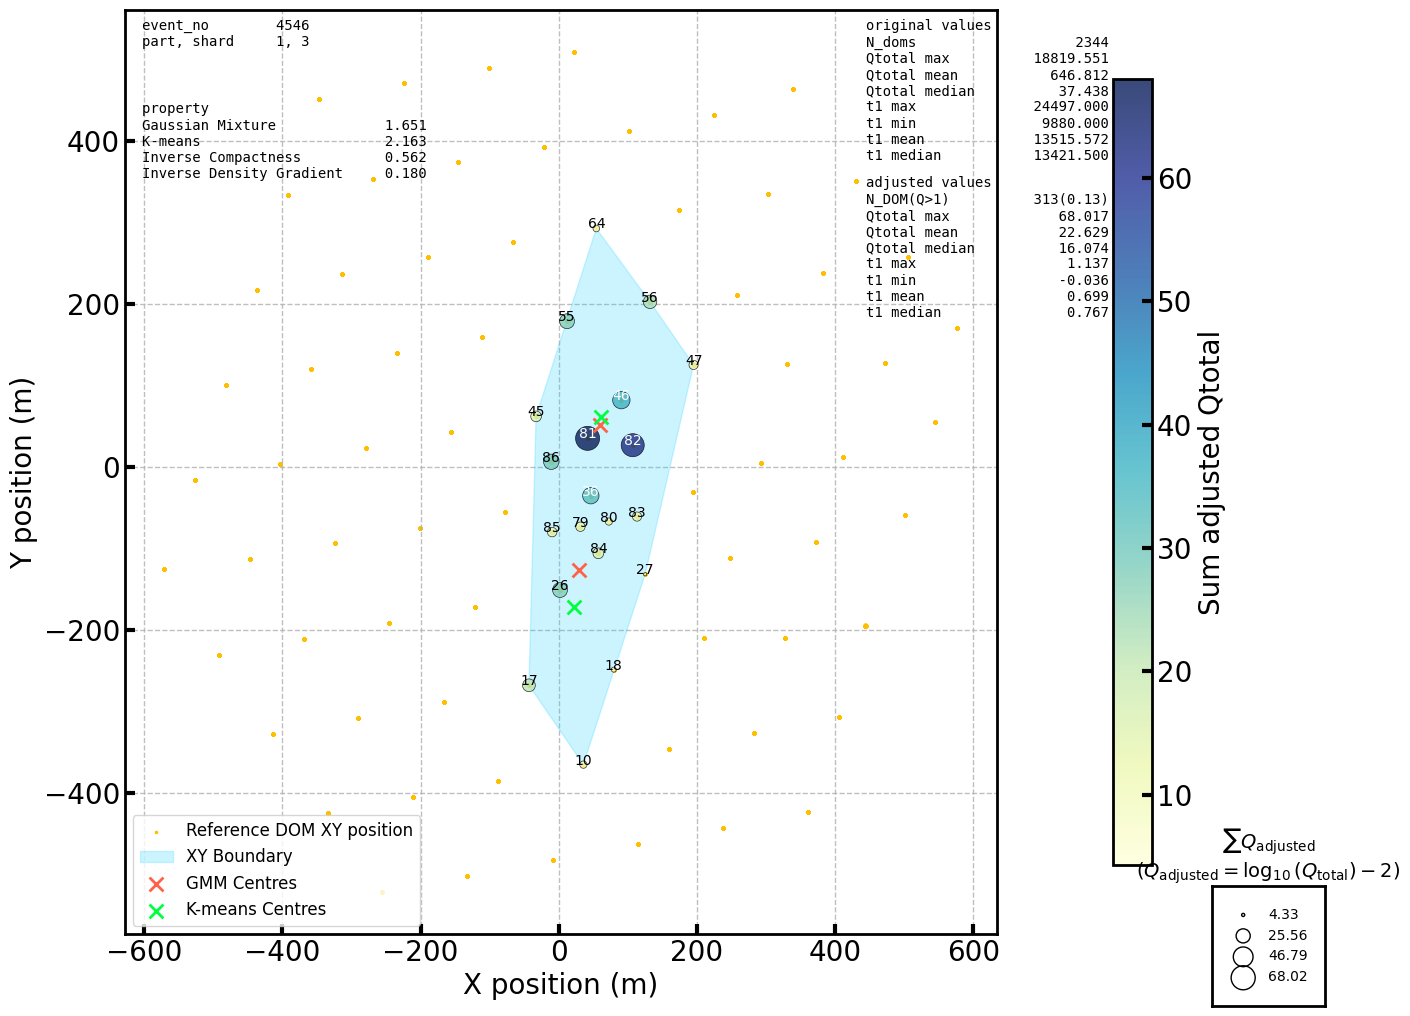

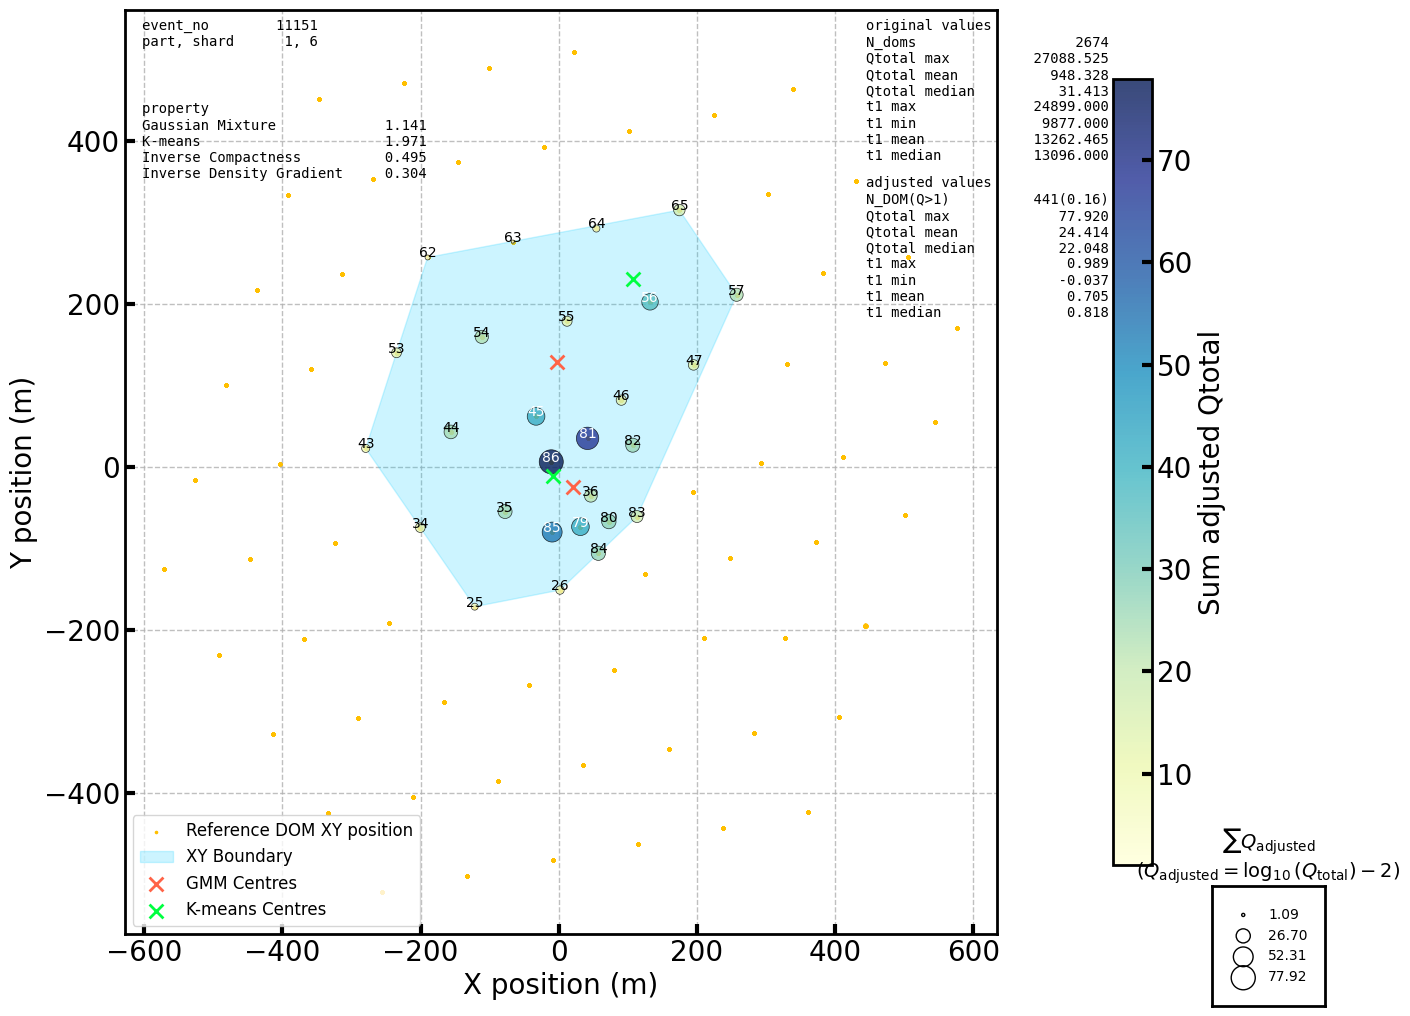

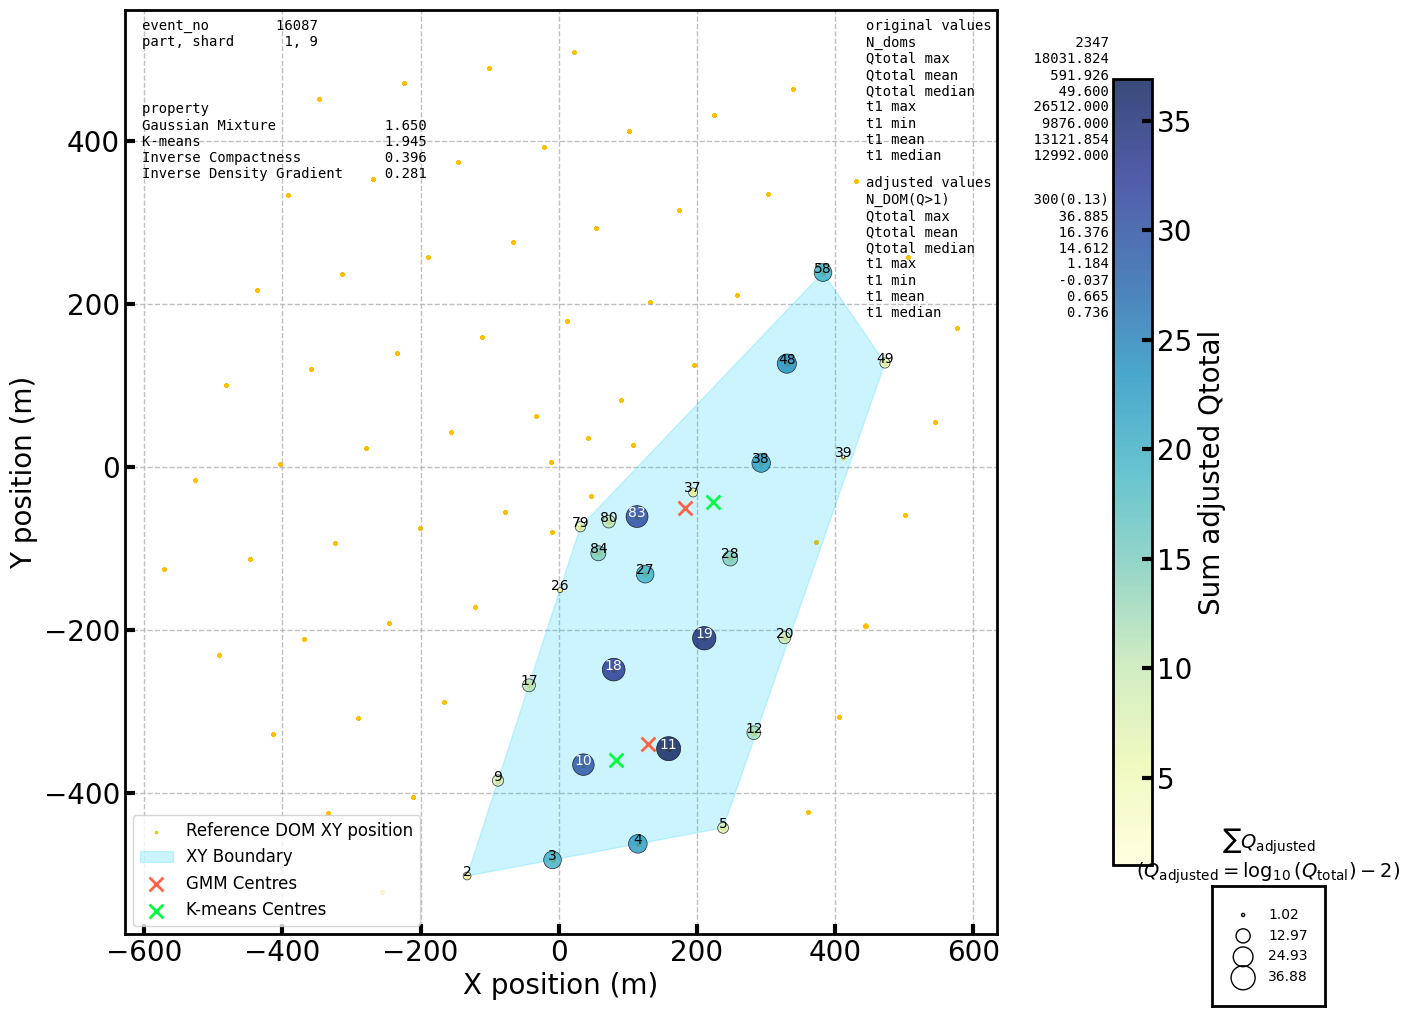

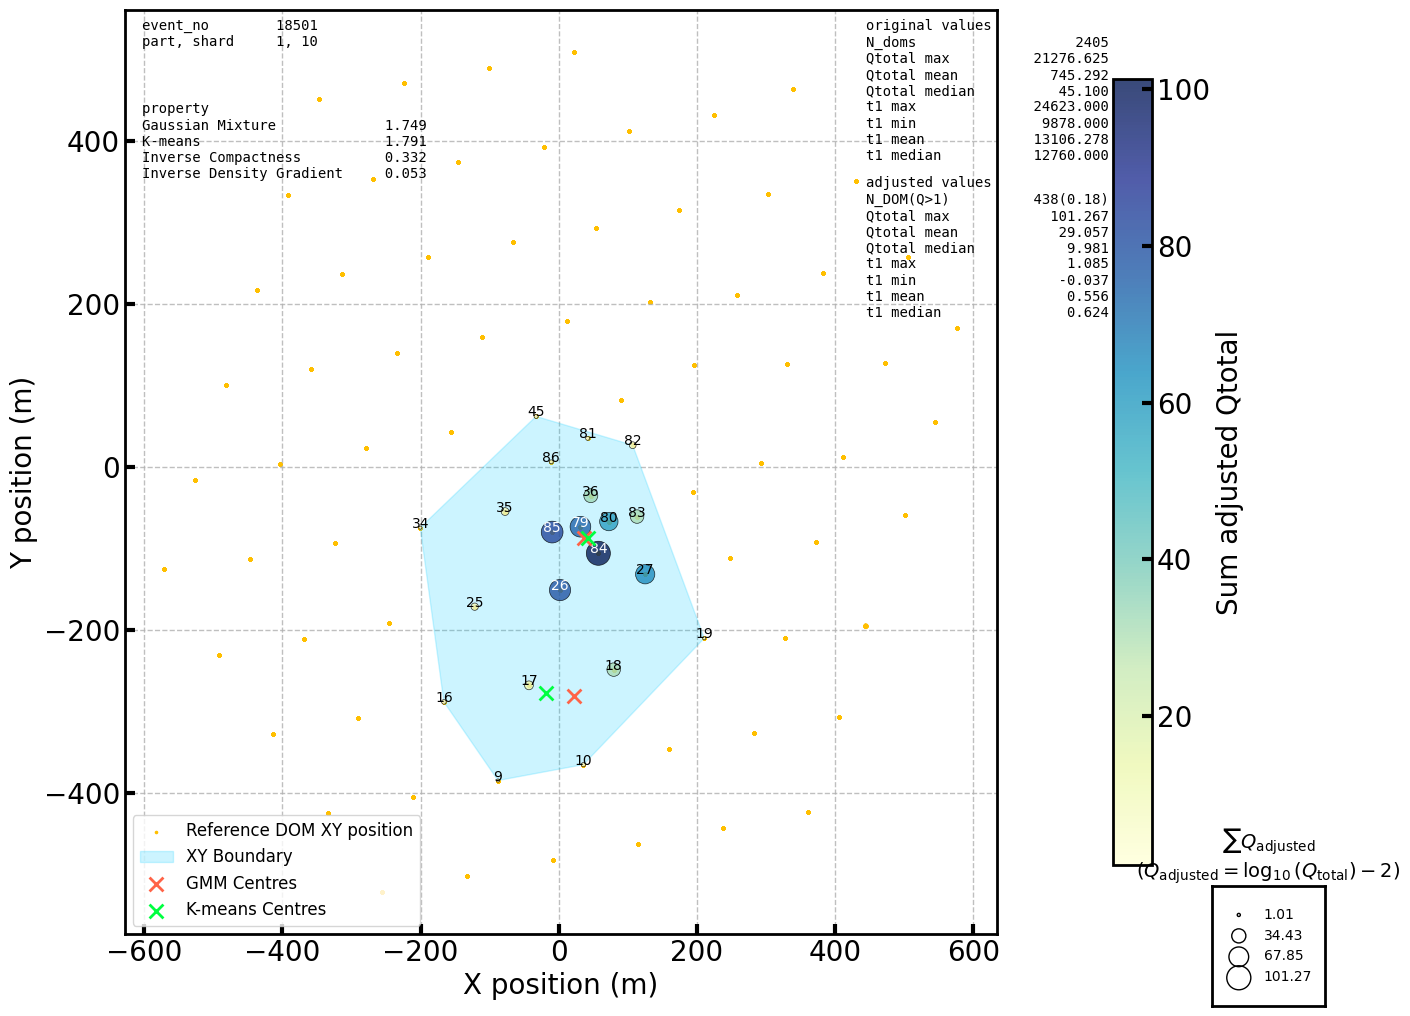

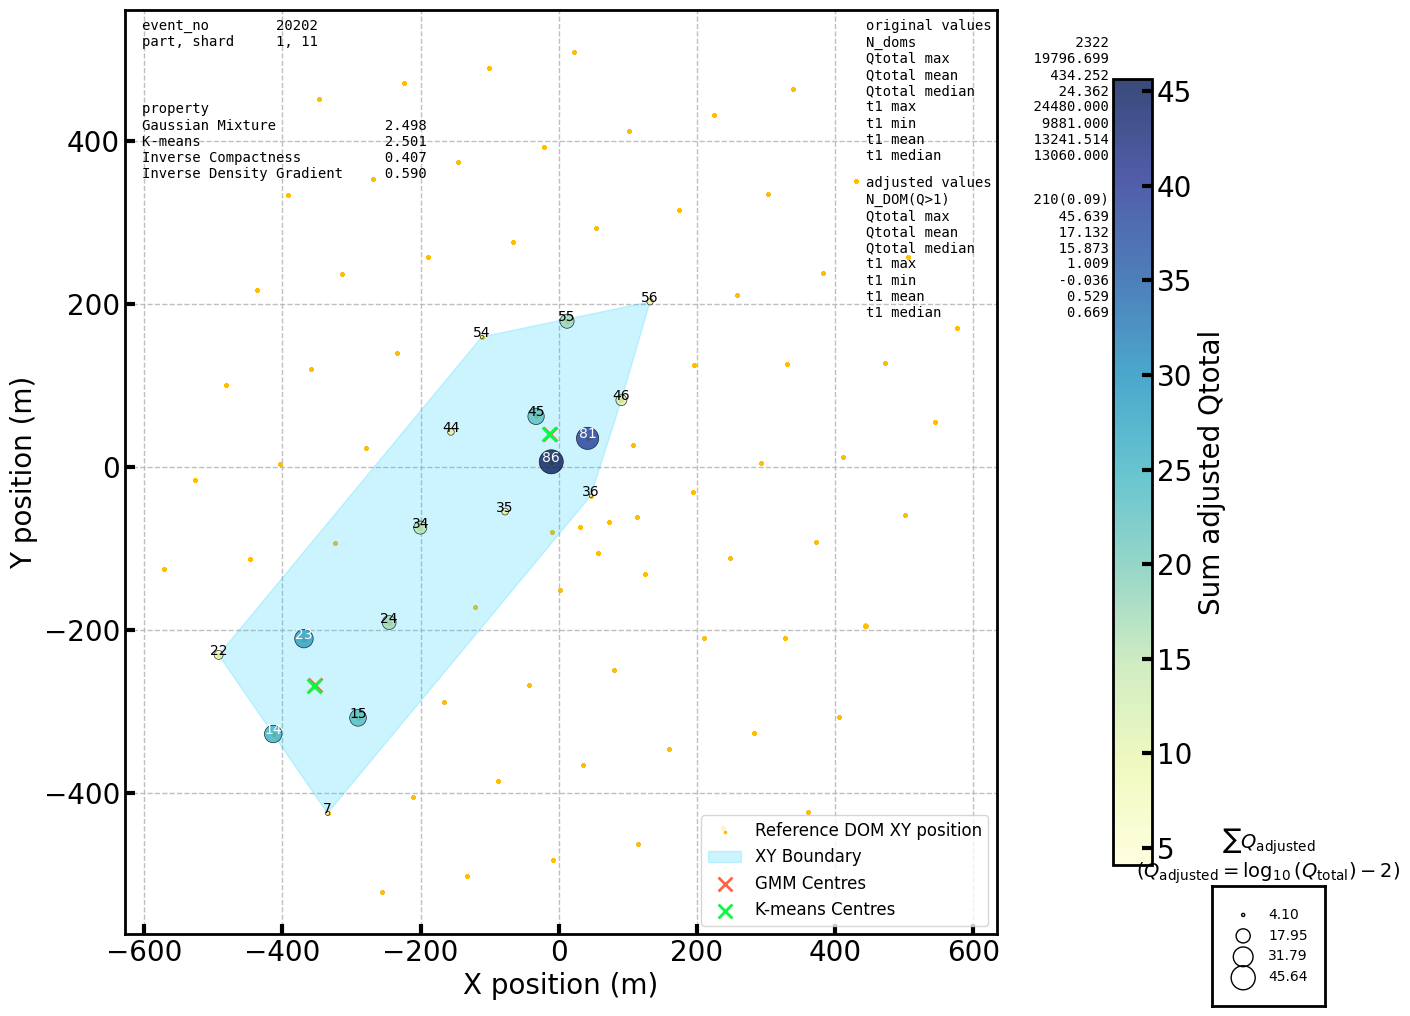

In [36]:
plot_events_from_this_part(root_before_subdir = root_dir_noCR_CC_IN, 
                           subdir = EnergyRange.ER_1_PEV_100_PEV.MU, 
                           part = 1, 
                           N_doms_cut = 2300, 
                           Q_cut=1, elev=50, azim=105)
# 